In [1]:
import ast
import pathlib
import sys

import numpy as np
import pandas as pd
import toml
import torch
from sklearn import preprocessing

sys.path.append("../..")


import matplotlib.pyplot as plt
import seaborn as sns
from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    output_stats,
    parameter_set,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)

sys.path.append("../../..")
import argparse

## Papermill is used for executing notebooks in the CLI with multiple parameters
Here the `injected-parameters` cell is used to inject parameters into the notebook via papermill.
This enables multiple notebooks to be executed with different parameters, preventing to manually update parameters or have multiple copies of the notebook.

In [ ]:
# set up the parser
parser = argparse.ArgumentParser(description="Train MLP model")

# add arguments to parser
parser.add_argument(
    "--CELL_TYPE",
    type=str,
    default="all",
    help="Cell type to train model on. Default is all",
)

parser.add_argument(
    "--MODEL_NAME",
    type=str,
    default="MLP",
    help="Model name to train. Default is MLP",
)

parser.add_argument(
    "--SHUFFLE",
    type=str,
    default="False",
    help="Shuffle data before training. Default is False",
)

# parse the arguments
args = parser.parse_args()

CELL_TYPE = args.CELL_TYPE
MODEL_NAME = args.MODEL_NAME
SHUFFLE = args.SHUFFLE
SHUFFLE = ast.literal_eval(SHUFFLE)
print(CELL_TYPE, MODEL_NAME, SHUFFLE)

In [2]:
CELL_TYPE = "SHSY5Y"
MODEL_NAME = "MultiClass_MLP"
SHUFFLE = False

In [3]:
ml_configs_file = pathlib.Path("../../MLP_utils/multi_class_config.toml").resolve(
    strict=True
)
ml_configs = toml.load(ml_configs_file)
params = Parameters()
mlp_params = parameter_set(params, ml_configs)

# overwrite params via command line arguments from papermill
mlp_params.CELL_TYPE = CELL_TYPE
mlp_params.MODEL_NAME = MODEL_NAME

mlp_params.MODEL_NAME = MODEL_NAME
mlp_params.SHUFFLE = SHUFFLE

# load in the class weights
class_weights_file_path = pathlib.Path(
    f"../../0.hyperparameter_optimization/class_weights/{CELL_TYPE}/multi_class/class_weights.txt"
).resolve(strict=True)
# read the class weights into a list for use in the loss function as a list
class_weights = []
with open(class_weights_file_path, "r") as f:
    for line in f:
        class_weights.append(float(line.strip()))
# check the class weights are correct
print(class_weights)

[0.954878893196544, 0.4803479499984947, 0.5647731568049614]


In [4]:
# Import Data
# set data file path under pathlib path for multi-system use

file_path = pathlib.Path(
    f"../../../data/{mlp_params.CELL_TYPE}_preprocessed_sc_norm.parquet"
).resolve(strict=True)

df1 = pd.read_parquet(file_path)

In [5]:
# get paths for toml files
ground_truth_file_path = pathlib.Path(f"../../MLP_utils/ground_truth.toml").resolve(
    strict=True
)
treatment_splits_file_path = pathlib.Path(f"../../MLP_utils/splits.toml").resolve(
    strict=True
)
# read toml files
ground_truth = toml.load(ground_truth_file_path)
treatment_splits = toml.load(treatment_splits_file_path)

In [6]:
# get information from toml files
apoptosis_groups_list = ground_truth["Apoptosis"]["apoptosis_groups_list"]
pyroptosis_groups_list = ground_truth["Pyroptosis"]["pyroptosis_groups_list"]
healthy_groups_list = ground_truth["Healthy"]["healthy_groups_list"]

#### Set up Data to be compatible with model

##### Classification Models:
Comment out code if using regression

In [7]:
np.random.seed(0)
if ast.literal_eval(mlp_params.DATA_SUBSET_OPTION):
    df1 = df1.groupby("oneb_Metadata_Treatment_Dose_Inhibitor_Dose").apply(
        lambda x: x.sample(n=mlp_params.DATA_SUBSET_NUMBER, random_state=0)
    )
    print("Data Subset Is On")
    print(f"Data is subset to {mlp_params.DATA_SUBSET_NUMBER} per treatment group")
    print(df1.shape)
    df1.reset_index(drop=True, inplace=True)
else:
    print("Data Subset Is Off")

Data Subset Is Off


In [8]:
# add apoptosis, pyroptosis and healthy columns to dataframe
df1["apoptosis"] = df1.apply(
    lambda row: row["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    in apoptosis_groups_list,
    axis=1,
)
df1["pyroptosis"] = df1.apply(
    lambda row: row["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    in pyroptosis_groups_list,
    axis=1,
)
df1["healthy"] = df1.apply(
    lambda row: row["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    in healthy_groups_list,
    axis=1,
)

# merge apoptosis, pyroptosis, and healthy columns into one column
df1["labels"] = df1.apply(
    lambda row: "apoptosis"
    if row["apoptosis"]
    else "pyroptosis"
    if row["pyroptosis"]
    else "healthy",
    axis=1,
)
# # drop apoptosis, pyroptosis, and healthy columns
df1.drop(columns=["apoptosis", "pyroptosis", "healthy"], inplace=True)

In [9]:
# set path for index file
index_file_path = pathlib.Path(
    f"../../0.hyperparameter_optimization/indexes/{params.CELL_TYPE}/multi_class/{params.MODEL_NAME}_data_split_indexes.tsv"
).resolve(strict=True)

# read index file
index_df = pd.read_csv(index_file_path, sep="\t")
index_df.head()

,labeled_data_index,label
0,379883,train
1,6688,train
2,293841,train
3,117560,train
4,213514,train


In [10]:
# get train, validation, test, and holdout indexes
train_indexes = index_df.loc[index_df["label"] == "train"]["labeled_data_index"]
val_indexes = index_df.loc[index_df["label"] == "val"]["labeled_data_index"]
test_indexes = index_df.loc[index_df["label"] == "test"]["labeled_data_index"]
holdout_indexes = index_df.loc[index_df["label"] == "holdout"]["labeled_data_index"]
print(train_indexes.shape, val_indexes.shape, test_indexes.shape, holdout_indexes.shape)
assert (
    train_indexes.shape[0]
    + val_indexes.shape[0]
    + test_indexes.shape[0]
    + holdout_indexes.shape[0]
) == index_df.shape[0]

(165097,) (41275,) (240629,) (150901,)


In [11]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df1.columns[df1.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df1[df_metadata]
df_descriptive["labels"] = df1["labels"]
df_values = df1.drop(columns=df_metadata)

/tmp/ipykernel_17883/4045983864.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_descriptive['labels'] = df1['labels']


In [12]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["new_labels"] = le.fit_transform(df_values["labels"])
# get mini dataframe that contains the decoder
df_labels = df_values[["labels", "new_labels"]]
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "labels",
        "new_labels",
    ],
    axis=1,
)
df_values_Y = df_values["new_labels"]
df_values_Y.unique()
df_labels.drop_duplicates(inplace=True)
# pandas chaining to reset index and drop old index
df_labels.reset_index(drop=True, inplace=True)

/tmp/ipykernel_17883/1683257534.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels.drop_duplicates(inplace=True)


In [13]:
print(train_indexes.shape, val_indexes.shape, test_indexes.shape, holdout_indexes.shape)
print(
    train_indexes.shape[0]
    + val_indexes.shape[0]
    + test_indexes.shape[0]
    + holdout_indexes.shape[0]
)

(165097,) (41275,) (240629,) (150901,)
597902


In [14]:
# get the train, validation, test, and holdout dataframes from the indexes
X_train = df_values_X.iloc[train_indexes.values]
X_val = df_values_X.iloc[val_indexes.values]
X_test = df_values_X.iloc[test_indexes.values]
X_holdout = df_values_X.iloc[holdout_indexes.values]

Y_train = df_values_Y.iloc[train_indexes.values]
Y_val = df_values_Y.iloc[val_indexes.values]
Y_test = df_values_Y.iloc[test_indexes.values]
Y_holdout = df_values_Y.iloc[holdout_indexes.values]

metadata_train = df_descriptive.iloc[train_indexes.values]
metadata_val = df_descriptive.iloc[val_indexes.values]
metadata_test = df_descriptive.iloc[test_indexes.values]
metadata_holdout = df_descriptive.iloc[holdout_indexes.values]

In [15]:
print(
    Y_train[Y_train == 0].shape,
    Y_train[Y_train == 1].shape,
    Y_train[Y_train == 2].shape,
)
print(Y_val[Y_val == 0].shape, Y_val[Y_val == 1].shape, Y_val[Y_val == 2].shape)
print(Y_test[Y_test == 0].shape, Y_test[Y_test == 1].shape, Y_test[Y_test == 2].shape)
print(
    Y_holdout[Y_holdout == 0].shape,
    Y_holdout[Y_holdout == 1].shape,
    Y_holdout[Y_holdout == 2].shape,
)

(7972,) (93463,) (63662,)
(1993,) (23367,) (15915,)
(9965,) (116830,) (113834,)
(7048,) (77041,) (66812,)


In [16]:
# reset indexes for all dataframes
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_holdout.reset_index(drop=True, inplace=True)

Y_train.reset_index(drop=True, inplace=True)
Y_val.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)
Y_holdout.reset_index(drop=True, inplace=True)

In [17]:
print(X_train.shape, X_val.shape, X_test.shape, X_holdout.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape, Y_holdout.shape)

(165097, 1251) (41275, 1251) (240629, 1251) (150901, 1251)
(165097,) (41275,) (240629,) (150901,)


#### Split Data - All Models can proceed through this point

In [18]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

In [19]:
mlp_params.IN_FEATURES = X_train.shape[1]
print("Number of in features: ", mlp_params.IN_FEATURES)
if mlp_params.MODEL_TYPE == "Regression":
    mlp_params.OUT_FEATURES = 1
else:
    mlp_params.OUT_FEATURES = len(df_values["labels"].unique())

print("Number of out features: ", mlp_params.OUT_FEATURES)

if mlp_params.OUT_FEATURES > 2:
    mlp_params.MODEL_TYPE = "Multi_Class"
elif mlp_params.OUT_FEATURES == 2:
    mlp_params.OUT_FEATURES = mlp_params.OUT_FEATURES - 1
    mlp_params.MODEL_TYPE = "Binary_Classification"
elif mlp_params.OUT_FEATURES == 1:
    mlp_params.MODEL_TYPE = "Regression"
else:
    pass
print(mlp_params.MODEL_TYPE)

Number of in features:  1251
Number of out features:  3
Multi_Class


In [20]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=mlp_params.BATCH_SIZE, shuffle=mlp_params.SHUFFLE
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=mlp_params.BATCH_SIZE, shuffle=mlp_params.SHUFFLE
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=1, shuffle=mlp_params.SHUFFLE
)

In [21]:
# call the optimized training model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    mlp_params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    params,
    mlp_params.MODEL_NAME,
    mlp_params.SHUFFLE,
    class_weights=class_weights,
)
# get training_metrics
if mlp_params.MODEL_TYPE == "Regression":
    training_stats = pd.DataFrame(
        zip(train_loss, valid_loss, epochs_ran),
        columns=["train_loss", "valid_loss", "epochs_ran"],
    )
else:
    training_stats = pd.DataFrame(
        zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
        columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
    )

SGD
Epoch 0: Validation loss decreased (inf --> 0.598038).  Saving model ...
	 Train_Loss: 0.6509 Train_Acc: 70.520 Val_Loss: 0.5980  BEST VAL Loss: 0.5980  Val_Acc: 71.901

Epoch 1: Validation loss decreased (0.598038 --> 0.585404).  Saving model ...
	 Train_Loss: 0.6169 Train_Acc: 72.995 Val_Loss: 0.5854  BEST VAL Loss: 0.5854  Val_Acc: 73.085

Epoch 2: Validation loss decreased (0.585404 --> 0.576750).  Saving model ...
	 Train_Loss: 0.5973 Train_Acc: 74.126 Val_Loss: 0.5768  BEST VAL Loss: 0.5768  Val_Acc: 73.764

Epoch 3: Validation loss decreased (0.576750 --> 0.570918).  Saving model ...
	 Train_Loss: 0.5834 Train_Acc: 74.819 Val_Loss: 0.5709  BEST VAL Loss: 0.5709  Val_Acc: 74.219

Epoch 4: Validation loss decreased (0.570918 --> 0.566008).  Saving model ...
	 Train_Loss: 0.5725 Train_Acc: 75.301 Val_Loss: 0.5660  BEST VAL Loss: 0.5660  Val_Acc: 74.432

Epoch 5: Validation loss decreased (0.566008 --> 0.562060).  Saving model ...
	 Train_Loss: 0.5633 Train_Acc: 75.803 Val_Loss:

In [22]:
# create a dataframe to store the model stats
model_stats_df = pd.DataFrame(
    columns=[
        "label",
        "metric",
        "value",
        "group",
        "shuffled_data",
    ]
)
# check empty dataframe
model_stats_df

,label,metric,value,group,shuffled_data


/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1015: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1016: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


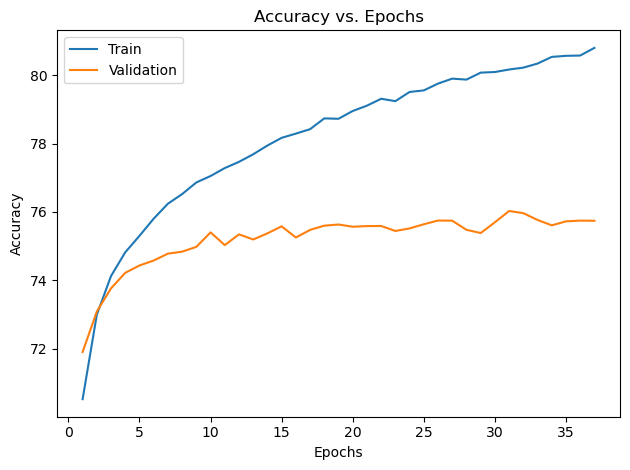

In [23]:
if mlp_params.MODEL_TYPE == "Regression":
    pass
else:
    plot_metric_vs_epoch(
        training_stats,
        x="epochs_ran",
        y1="train_acc",
        y2="valid_acc",
        title="Accuracy vs. Epochs",
        x_axis_label="Epochs",
        y_axis_label="Accuracy",
        params=params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )

/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1015: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1016: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


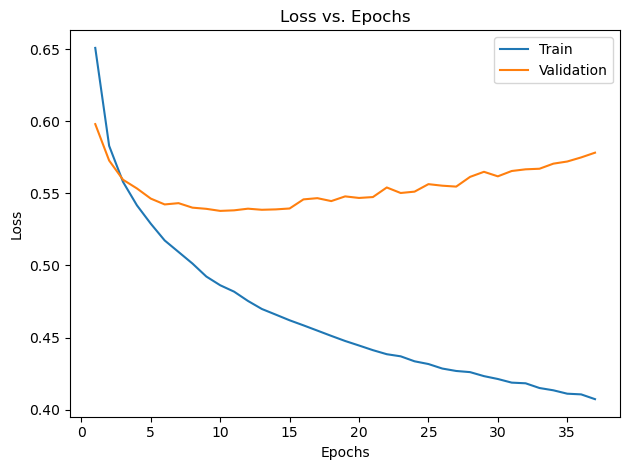

In [24]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_loss",
    y2="valid_loss",
    title="Loss vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Loss",
    params=params,
    model_name=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

### Test Models on training data

In [25]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        train_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        train_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

MultiClass_MLP


In [26]:
stats_df = output_stats(
    y_pred_list,
    Y_train,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      7972
           1       0.83      0.83      0.83     93463
           2       0.76      0.76      0.76     63662

    accuracy                           0.81    165097
   macro avg       0.84      0.84      0.84    165097
weighted avg       0.81      0.81      0.81    165097



/tmp/ipykernel_17883/3705935474.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [27]:
stats_df["group"] = "train"
stats_df["shuffled_data"] = mlp_params.SHUFFLE
stats_df
model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

### Test models on Validation data

In [28]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

MultiClass_MLP


In [29]:
stats_df = output_stats(
    y_pred_list,
    Y_val,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.79      0.75      0.77      1993
           1       0.79      0.79      0.79     23367
           2       0.70      0.71      0.70     15915

    accuracy                           0.76     41275
   macro avg       0.76      0.75      0.76     41275
weighted avg       0.76      0.76      0.76     41275



/tmp/ipykernel_17883/603564049.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [30]:
stats_df["group"] = "validation"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

/tmp/ipykernel_17883/1865218578.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


In [31]:
mlp_params.MODEL_NAME

'MultiClass_MLP'

### Testing on the test data

In [32]:
# create a dataframe to store the model confusion matrix
data_split_conf_mat_df_all = pd.DataFrame(
    columns=["True_Label", "Predicted_Label", "Count", "data_split", "Recall"]
)

In [33]:
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

MultiClass_MLP


              precision    recall  f1-score   support

           0       0.77      0.76      0.76      9965
           1       0.71      0.79      0.75    116830
           2       0.76      0.68      0.72    113834

    accuracy                           0.73    240629
   macro avg       0.75      0.74      0.74    240629
weighted avg       0.74      0.73      0.73    240629

Precision for class 0: 0.7712090163934426
Recall for class 0: 0.7553437029603612
Precision for class 1: 0.7113581507612329
Recall for class 1: 0.7870666780792605
Precision for class 2: 0.7602086511490576
Recall for class 2: 0.678540682045786
3


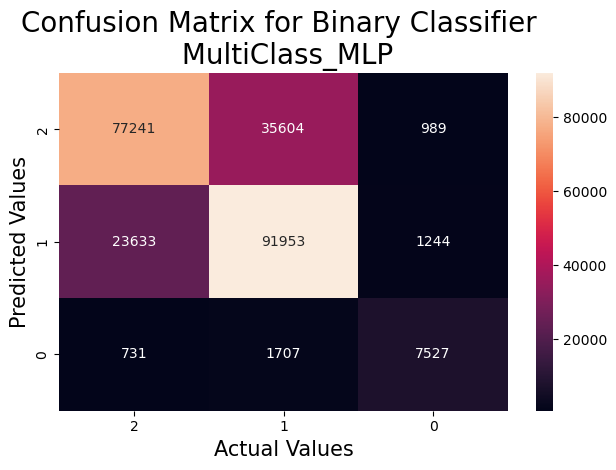

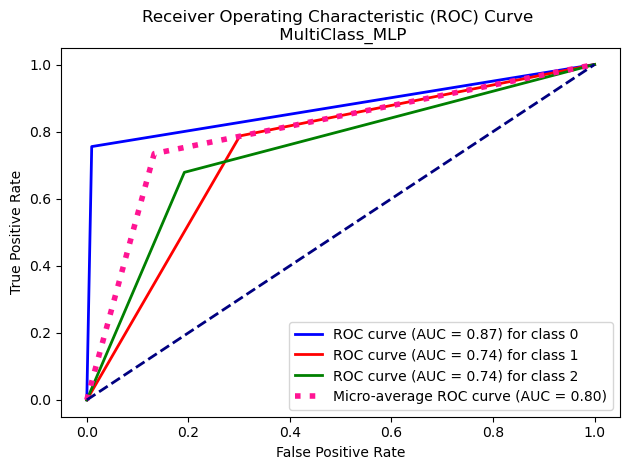

In [34]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_test,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_test,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [35]:
metadata_test

,Metadata_cell_type,Metadata_Well,Metadata_number_of_singlecells,Metadata_incubation inducer (h),Metadata_inhibitor,Metadata_inhibitor_concentration,Metadata_inhibitor_concentration_unit,Metadata_inducer1,Metadata_inducer1_concentration,Metadata_inducer1_concentration_unit,...,Metadata_inducer2_concentration_unit,Metadata_ImageNumber,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,labels
0,SH-SY5Y,B13,3765,6,Media_ctr,nan,None,media_ctr,0.0,None,...,None,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,1,1,3,3,media_ctr,0.0_None,healthy
6,SH-SY5Y,B13,3765,6,Media_ctr,nan,None,media_ctr,0.0,None,...,None,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,7,7,9,9,media_ctr,0.0_None,healthy
7,SH-SY5Y,B13,3765,6,Media_ctr,nan,None,media_ctr,0.0,None,...,None,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,8,8,10,10,media_ctr,0.0_None,healthy
8,SH-SY5Y,B13,3765,6,Media_ctr,nan,None,media_ctr,0.0,None,...,None,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,9,9,11,11,media_ctr,0.0_None,healthy
9,SH-SY5Y,B13,3765,6,Media_ctr,nan,None,media_ctr,0.0,None,...,None,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,10,10,12,12,media_ctr,0.0_None,healthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597895,SH-SY5Y,O23,3555,6,Media_ctr,nan,None,media_ctr,0.0,None,...,None,1246,*70117_20230210MM1_Gasdermin514_CP_BC430856,81,81,87,87,media_ctr,0.0_None,healthy
597896,SH-SY5Y,O23,3555,6,Media_ctr,nan,None,media_ctr,0.0,None,...,None,1246,*70117_20230210MM1_Gasdermin514_CP_BC430856,128,128,135,135,media_ctr,0.0_None,healthy
597898,SH-SY5Y,O23,3555,6,Media_ctr,nan,None,media_ctr,0.0,None,...,None,1247,*70117_20230210MM1_Gasdermin514_CP_BC430856,146,146,159,159,media_ctr,0.0_None,healthy
597899,SH-SY5Y,O23,3555,6,Media_ctr,nan,None,media_ctr,0.0,None,...,None,1247,*70117_20230210MM1_Gasdermin514_CP_BC430856,221,221,234,234,media_ctr,0.0_None,healthy


In [36]:
# merge the y_pred_list and Y_holdout into a dataframe
y_pred_df = pd.DataFrame(y_pred_list, columns=["y_pred"])
y_pred_df = pd.concat([y_pred_df, Y_test], axis=1)
y_pred_df = pd.concat([y_pred_df, X_test], axis=1)

In [37]:
# merge y_pred_df with metadata_holdout whiile keeping the index of metadata_holdout
metadata_test.reset_index(inplace=True)
y_pred_df = pd.concat([y_pred_df, metadata_test], axis=1)
# set the index to the index column
y_pred_df.set_index("index", inplace=True, drop=True)
y_pred_df

,y_pred,new_labels,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_Extent,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_0_0,...,Metadata_inducer2_concentration_unit,Metadata_ImageNumber,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,labels
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,0.806753,1.127894,-1.621196,-0.939418,-0.459493,-1.559829,-0.653718,-1.368565,...,None,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,1,1,3,3,media_ctr,0.0_None,healthy
6,1,1,0.446028,0.965526,-0.711945,-0.708833,1.346422,0.084637,0.303813,-1.016917,...,None,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,7,7,9,9,media_ctr,0.0_None,healthy
7,2,1,-0.316498,0.336804,-0.813935,0.016854,0.303227,0.310584,-0.867611,0.012472,...,None,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,8,8,10,10,media_ctr,0.0_None,healthy
8,1,1,-0.012046,-0.018079,-0.197359,-0.323890,-0.120228,0.258473,-1.462321,-0.347762,...,None,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,9,9,11,11,media_ctr,0.0_None,healthy
9,1,1,-0.353703,-0.767519,0.624540,0.064788,0.080988,1.166685,-0.322262,0.968496,...,None,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,10,10,12,12,media_ctr,0.0_None,healthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597895,1,1,-0.406369,1.290748,-0.220145,0.135402,2.218792,-0.427815,-0.926437,-0.815460,...,None,1246,*70117_20230210MM1_Gasdermin514_CP_BC430856,81,81,87,87,media_ctr,0.0_None,healthy
597896,1,1,-1.280182,0.907755,2.322952,2.120562,-0.362151,-1.114296,-0.015486,0.811810,...,None,1246,*70117_20230210MM1_Gasdermin514_CP_BC430856,128,128,135,135,media_ctr,0.0_None,healthy
597898,0,1,-0.575085,0.961826,0.394708,0.386171,0.600712,-0.471124,-1.101421,0.245070,...,None,1247,*70117_20230210MM1_Gasdermin514_CP_BC430856,146,146,159,159,media_ctr,0.0_None,healthy


In [38]:
# save the y_pred_df to a parquet file
# set path
y_pred_df_path = pathlib.Path(
    f"../../results/Multi_Class/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}/testing_single_cell_predictions.parquet"
)
# make path if it doesn't exist
y_pred_df_path.parent.mkdir(parents=True, exist_ok=True)
# save the dataframe
y_pred_df.to_parquet(y_pred_df_path)

In [39]:
# rename columns from the decoder dictionary
confusion_matrix_df.rename(
    columns={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)
confusion_matrix_df.rename(
    index={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)

In [40]:
confusion_matrix_df

,apoptosis,healthy,pyroptosis
apoptosis,7527,1707,731
healthy,1244,91953,23633
pyroptosis,989,35604,77241


In [41]:
confusion_matrices = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices = pd.melt(
    confusion_matrices,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices["data_split"] = "testing"
# sum of the columns of the confusion matrix gives the total number of samples per class
sum_of_columns = confusion_matrix_df.sum(axis=0)

In [42]:
confusion_matrices

,True_Label,Predicted_Label,Count,data_split
0,apoptosis,healthy,1707,testing
1,healthy,healthy,91953,testing
2,pyroptosis,healthy,35604,testing
3,apoptosis,apoptosis,7527,testing
4,healthy,apoptosis,1244,testing
5,pyroptosis,apoptosis,989,testing
6,apoptosis,pyroptosis,731,testing
7,healthy,pyroptosis,23633,testing
8,pyroptosis,pyroptosis,77241,testing


In [43]:
# normalize confusion matrix
# get the sum of each column to normalize the confusion matrix by the total number of samples per class

# divide the apotosis column by the sum of the apotosis column
confusion_matrix_df["apoptosis"] = confusion_matrix_df["apoptosis"] / sum_of_columns[0]
# divide the healthy column by the sum of the healthy column
confusion_matrix_df["healthy"] = confusion_matrix_df["healthy"] / sum_of_columns[1]
# divide the pyroptosis column by the sum of the pyroptosis column
confusion_matrix_df["pyroptosis"] = (
    confusion_matrix_df["pyroptosis"] / sum_of_columns[2]
)

In [44]:
confusion_matrix_df

,apoptosis,healthy,pyroptosis
apoptosis,0.771209,0.013206,0.007195
healthy,0.127459,0.711358,0.232597
pyroptosis,0.101332,0.275436,0.760209


In [45]:
confusion_matrices_recall = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices_recall = pd.melt(
    confusion_matrices_recall,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices_recall.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices_recall["data_split"] = "testing"
confusion_matrices_recall.rename(columns={"Count": "Recall"}, inplace=True)
data_split_conf_mat_df = pd.merge(
    confusion_matrices,
    confusion_matrices_recall,
    on=["True_Label", "Predicted_Label", "data_split"],
)
data_split_conf_mat_df["shuffled_data"] = mlp_params.SHUFFLE
data_split_conf_mat_df_all = pd.concat(
    [data_split_conf_mat_df_all, data_split_conf_mat_df], axis=0
)

In [46]:
data_split_conf_mat_df_all

,True_Label,Predicted_Label,Count,data_split,Recall,shuffled_data
0,apoptosis,healthy,1707,testing,0.013206,False
1,healthy,healthy,91953,testing,0.711358,False
2,pyroptosis,healthy,35604,testing,0.275436,False
3,apoptosis,apoptosis,7527,testing,0.771209,False
4,healthy,apoptosis,1244,testing,0.127459,False
5,pyroptosis,apoptosis,989,testing,0.101332,False
6,apoptosis,pyroptosis,731,testing,0.007195,False
7,healthy,pyroptosis,23633,testing,0.232597,False
8,pyroptosis,pyroptosis,77241,testing,0.760209,False


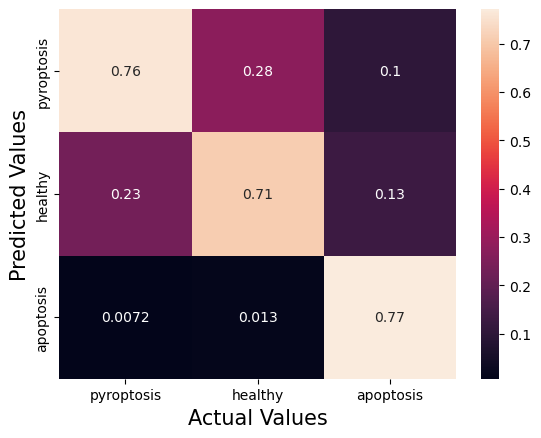

In [47]:
ax = sns.heatmap(confusion_matrix_df, annot=True)
ax.invert_xaxis()
ax.invert_yaxis()
plt.xlabel("Actual Values", size=15)
plt.ylabel("Predicted Values", size=15)
plt.show()

In [48]:
stats_df = output_stats(
    y_pred_list,
    Y_test,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      9965
           1       0.71      0.79      0.75    116830
           2       0.76      0.68      0.72    113834

    accuracy                           0.73    240629
   macro avg       0.75      0.74      0.74    240629
weighted avg       0.74      0.73      0.73    240629



/tmp/ipykernel_17883/2182903883.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [49]:
stats_df["group"] = "test"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

/tmp/ipykernel_17883/1771591469.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


## Test the hold out wells

MultiClass_MLP
              precision    recall  f1-score   support

           0       0.82      0.75      0.78      7048
           1       0.75      0.78      0.76     77041
           2       0.74      0.70      0.72     66812

    accuracy                           0.75    150901
   macro avg       0.77      0.75      0.76    150901
weighted avg       0.75      0.75      0.75    150901

Precision for class 0: 0.8152474638794959
Recall for class 0: 0.7525539160045402
Precision for class 1: 0.7460633573716957
Recall for class 1: 0.7828818421360055
Precision for class 2: 0.7407319989929506
Recall for class 2: 0.7045889959887446
3


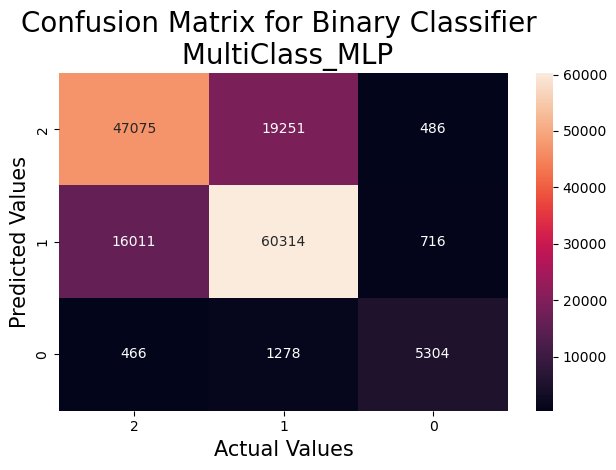

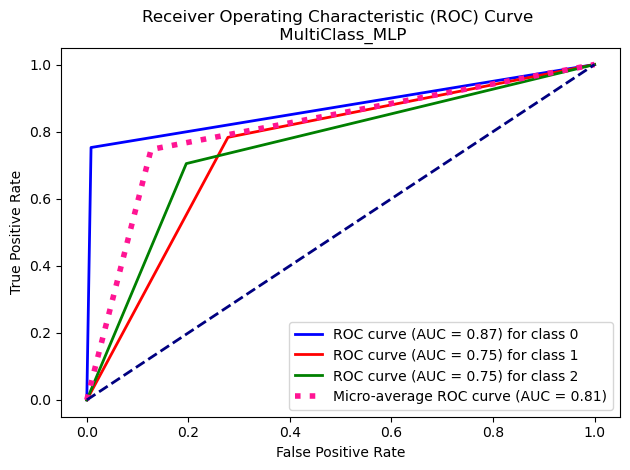

In [50]:
holdout_data = Dataset_formatter(
    torch.FloatTensor(X_holdout.values), torch.FloatTensor(Y_holdout.values)
)

# convert data class into a dataloader to be compatible with pytorch
holdout_loader = torch.utils.data.DataLoader(
    dataset=holdout_data, batch_size=1, shuffle=mlp_params.SHUFFLE
)

# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        holdout_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        holdout_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_holdout):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_holdout,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_holdout,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [51]:
# merge the y_pred_list and Y_holdout into a dataframe
y_pred_df = pd.DataFrame(y_pred_list, columns=["y_pred"])
y_pred_df = pd.concat([y_pred_df, Y_holdout], axis=1)
y_pred_df = pd.concat([y_pred_df, X_holdout], axis=1)

In [52]:
# merge y_pred_df with metadata_holdout whiile keeping the index of metadata_holdout
metadata_holdout.reset_index(inplace=True)
y_pred_df = pd.concat([y_pred_df, metadata_holdout], axis=1)
# set the index to the index column
y_pred_df.set_index("index", inplace=True, drop=True)

In [53]:
# save the y_pred_df to a parquet file
# set path
y_pred_df_path = pathlib.Path(
    f"../../results/Multi_Class/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}/holdout_single_cell_predictions.parquet"
)
# make path if it doesn't exist
y_pred_df_path.parent.mkdir(parents=True, exist_ok=True)
# save the dataframe
y_pred_df.to_parquet(y_pred_df_path)

In [54]:
# rename columns from the decoder dictionary
confusion_matrix_df.rename(
    columns={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)
# rename index from the decoder dictionary
confusion_matrix_df.rename(
    index={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)

In [55]:
confusion_matrices = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices = pd.melt(
    confusion_matrices,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices["data_split"] = "holdout"
# sum of the columns of the confusion matrix gives the total number of samples per class
sum_of_columns = confusion_matrix_df.sum(axis=0)

In [56]:
confusion_matrices

,True_Label,Predicted_Label,Count,data_split
0,apoptosis,healthy,1278,holdout
1,healthy,healthy,60314,holdout
2,pyroptosis,healthy,19251,holdout
3,apoptosis,apoptosis,5304,holdout
4,healthy,apoptosis,716,holdout
5,pyroptosis,apoptosis,486,holdout
6,apoptosis,pyroptosis,466,holdout
7,healthy,pyroptosis,16011,holdout
8,pyroptosis,pyroptosis,47075,holdout


In [57]:
# normalize confusion matrix
# get the sum of each column to normalize the confusion matrix by the total number of samples per class

# divide the apotosis column by the sum of the apotosis column
confusion_matrix_df["apoptosis"] = confusion_matrix_df["apoptosis"] / sum_of_columns[0]
# divide the healthy column by the sum of the healthy column
confusion_matrix_df["healthy"] = confusion_matrix_df["healthy"] / sum_of_columns[1]
# divide the pyroptosis column by the sum of the pyroptosis column
confusion_matrix_df["pyroptosis"] = (
    confusion_matrix_df["pyroptosis"] / sum_of_columns[2]
)

In [58]:
# change the order of the columns
confusion_matrix_df = confusion_matrix_df[["healthy", "apoptosis", "pyroptosis"]]
# change the order of the index
confusion_matrix_df = confusion_matrix_df.reindex(
    index=["healthy", "apoptosis", "pyroptosis"]
)

In [59]:
confusion_matrices_recall = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices_recall = pd.melt(
    confusion_matrices_recall,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices_recall.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices_recall["data_split"] = "holdout"
confusion_matrices_recall.rename(columns={"Count": "Recall"}, inplace=True)
data_split_conf_mat_df = pd.merge(
    confusion_matrices,
    confusion_matrices_recall,
    on=["True_Label", "Predicted_Label", "data_split"],
)
data_split_conf_mat_df["shuffled_data"] = mlp_params.SHUFFLE
data_split_conf_mat_df_all = pd.concat(
    [data_split_conf_mat_df_all, data_split_conf_mat_df], axis=0
)

/tmp/ipykernel_17883/3876124126.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data_split_conf_mat_df_all = pd.concat(


In [60]:
data_split_conf_mat_df

,True_Label,Predicted_Label,Count,data_split,Recall,shuffled_data
0,apoptosis,healthy,1278,holdout,0.015808,False
1,healthy,healthy,60314,holdout,0.746063,False
2,pyroptosis,healthy,19251,holdout,0.238128,False
3,apoptosis,apoptosis,5304,holdout,0.815247,False
4,healthy,apoptosis,716,holdout,0.110052,False
5,pyroptosis,apoptosis,486,holdout,0.074700,False
6,apoptosis,pyroptosis,466,holdout,0.007333,False
7,healthy,pyroptosis,16011,holdout,0.251935,False
8,pyroptosis,pyroptosis,47075,holdout,0.740732,False


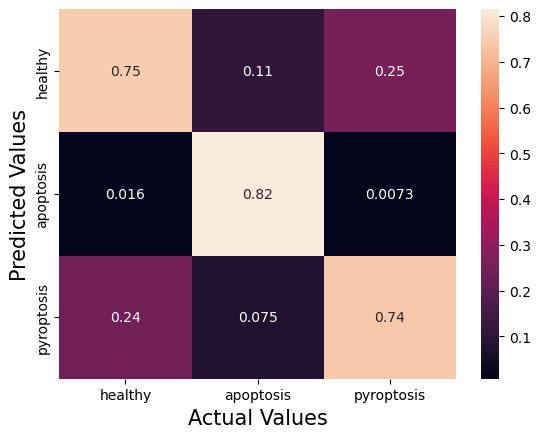

In [61]:
ax = sns.heatmap(confusion_matrix_df, annot=True)

plt.xlabel("Actual Values", size=15)
plt.ylabel("Predicted Values", size=15)
plt.show()

In [62]:
stats_df = output_stats(
    y_pred_list,
    Y_holdout,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.82      0.75      0.78      7048
           1       0.75      0.78      0.76     77041
           2       0.74      0.70      0.72     66812

    accuracy                           0.75    150901
   macro avg       0.77      0.75      0.76    150901
weighted avg       0.75      0.75      0.75    150901



/tmp/ipykernel_17883/2531832601.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [63]:
stats_df["group"] = "holdout"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)
model_stats_df

/tmp/ipykernel_17883/2184599894.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


,label,metric,value,group,shuffled_data
0,apoptosis,precision,0.924016,train,False
1,healthy,precision,0.834686,train,False
2,pyroptosis,precision,0.759180,train,False
3,accuracy,accuracy,0.809942,train,False
4,macro avg,precision,0.839294,train,False
...,...,...,...,...,...
19,healthy,support,77041.000000,holdout,False
20,pyroptosis,support,66812.000000,holdout,False
21,accuracy,accuracy,0.746801,holdout,False
22,macro avg,support,150901.000000,holdout,False


In [64]:
data_split_conf_mat_df_all

,True_Label,Predicted_Label,Count,data_split,Recall,shuffled_data
0,apoptosis,healthy,1707,testing,0.013206,False
1,healthy,healthy,91953,testing,0.711358,False
2,pyroptosis,healthy,35604,testing,0.275436,False
3,apoptosis,apoptosis,7527,testing,0.771209,False
4,healthy,apoptosis,1244,testing,0.127459,False
5,pyroptosis,apoptosis,989,testing,0.101332,False
6,apoptosis,pyroptosis,731,testing,0.007195,False
7,healthy,pyroptosis,23633,testing,0.232597,False
8,pyroptosis,pyroptosis,77241,testing,0.760209,False
0,apoptosis,healthy,1278,holdout,0.015808,False


In [65]:
# set path for the model confusion matrices
matrix_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
matrix_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
matrix_file = pathlib.Path(f"{matrix_path}/confusion_matrices.csv")
if matrix_file.exists():
    metrics_df = pd.read_csv(matrix_file)
    if len(metrics_df["shuffled_data"].unique()) > 1:
        pass
    elif metrics_df["shuffled_data"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([metrics_df, data_split_conf_mat_df_all], axis=0)
        metrics_df.to_csv(matrix_file, index=False)
else:
    data_split_conf_mat_df_all.to_csv(matrix_file, index=False)

In [66]:
# set path for the model training metrics
metrics_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
metrics_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
metrics_file = pathlib.Path(f"{metrics_path}/training_metrics.csv")
if metrics_file.exists():
    metrics_df = pd.read_csv(metrics_file)
    if len(metrics_df["shuffled_data"].unique()) > 1:
        pass
    elif metrics_df["shuffled_data"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([metrics_df, model_stats_df], axis=0)
        metrics_df.to_csv(metrics_file, index=False)
else:
    model_stats_df.to_csv(metrics_file, index=False)